Quality: 10, 962.6441040039062
Quality: 20, 1009.978515625
Quality: 30, 1064.7147216796875
Quality: 40, 1094.90380859375
Quality: 50, 1122.2366943359375
Quality: 60, 1150.2794189453125
Quality: 70, 1183.3199462890625
Quality: 80, 1217.1090087890625
Quality: 90, 1238.5328369140625


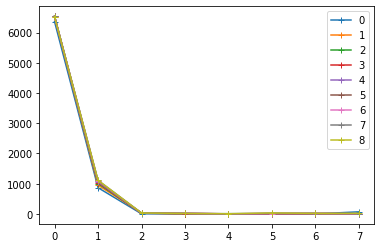

In [5]:
from typing import Tuple

import cv2
import einops
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision.io import encode_jpeg, read_image, write_png, ImageReadMode


def simulate_jpeg_compression(image: np.ndarray, jpeg_quality: int = 100) -> np.ndarray:
    compressed_image = image.copy()
    *_, encoded = cv2.imencode(".jpg", compressed_image, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])
    return cv2.imdecode(encoded, 1)


def fourier_transform_method(splitter, image):
    fft = torch.fft.fft2(splitter(image))
    fft = torch.abs(fft)
    return fft    


class SplitPatch:
    
    def __init__(self, window_size: Tuple[int, int]):
        self.window_size = window_size
        
    def __call__(self, image):
        return einops.rearrange(image, "c (h i) (w k) -> (h w c) i k", i=self.window_size[0], k=self.window_size[1])
    

def pca(tensor, n_components=3):
    assert tensor.shape[1] < tensor.shape[0]
    cov_mat = torch.matmul(tensor.transpose(0, 1), tensor) / (tensor.shape[0] - 1)
    eigen = torch.eig(cov_mat, eigenvectors=True)
    return torch.matmul(tensor, eigen[1][:, :n_components])

values = []
image = read_image("../ash-tree-disease.png", mode=ImageReadMode.RGB)[:, :664, :1200]
for quality in range(10, 100, 10):
    compressed_image = torch.from_numpy(simulate_jpeg_compression(image.permute(1, 2, 0).numpy(), jpeg_quality=quality)).permute(2, 0, 1)
    write_png(compressed_image, "a.png")
    fourier = fourier_transform_method(SplitPatch((8, 8)), image)
    compressed_fourier = fourier_transform_method(SplitPatch((8, 8)), compressed_image)

    # print(torch.abs(torch.linalg.eigvals(fourier)).mean(0))
    values.append(torch.abs(torch.linalg.eigvals(compressed_fourier).mean(0)).numpy())
    print(f"Quality: {quality}, {np.sum(values[-1][1:])}")
    
for value in values:
    plt.plot(value, "+-")
plt.legend(list(range(len(values))))
plt.show()

In [12]:
from typing import Callable, Iterable

from sklearn.ensemble import RandomForestRegressor


def create_dataset(dataset: Iterable, extraction_function: Callable, features_length: int = 8):
    
    feats = np.zeros((len(dataset), features_length))
    targets = np.zeros((len(dataset)))
    
    for idx, (image, is_compressed, compression_level) in enumerate(dataset):
        features = extraction_function(image)
        feats[idx, :] = features
        targets[idx] = compression_level
    
    return feats, targets

samples, targets = create_dataset(None, None, 8)
regressor = RandomForestRegressor(n_estimators=20)
regressor.fit(samples, targets)

tensor([6501.6836, 1139.8660,  186.0925,  107.0759,   91.9760,  254.9387,
         149.6133,   83.8962])
tensor([6.4680e+03, 1.1195e+03, 1.8118e+01, 1.6690e+01, 1.1241e+01, 3.3255e-01,
        6.1187e-01, 6.1187e-01])


In [ ]:
from collections import namedtuple
import glob
import os
import random

import torch
import torch.utils.data as data


RandomMinMax = namedtuple("RandomMinMax", ["min", "max"])


class SimpleClassificationDataset(data.Dataset):
    
    def __init__(self, image_folder, transforms, compression_probability: float = 0.5, jpeg_quality: RandomMinMax = RandomMinMax(min=20, max=95)):
        self.images = glob.glob(os.path.join(image_folder, "*"))
        self.transforms = transforms
        self.compression_probability = compression_probability
        self.jpeg_quality = jpeg_quality
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image = cv2.imread(self.images[item])
        if is_compression := (random.random() < self.compression_probability):
            compression_level = random.randint(self.jpeg_quality.min, self.jpeg_quality.max)
            image = simulate_jpeg_compression(image, jpeg_quality=compression_level)
        else:
            compression_level = 100
        image = self.transforms(image)
        return image, torch.tensor([is_compression]).long(), compression_level